In [1]:
data = 'final_data.csv'

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import operator
import string
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
#Import necessary libraries
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Utility
import os
from collections import Counter

In [3]:
df = pd.read_csv(data)

In [4]:
df.isnull().sum()

Unnamed: 0           0
Text                82
Mental_condition     0
dtype: int64

In [5]:
#drop null values
df.dropna(inplace=True)

In [6]:
df.rename(columns={'Text':'text','Mental_condition':'label'},inplace=True)
df['length'] = df['text'].apply(len)

In [7]:
df.head()

,Unnamed: 0,text,label,length
0,1086997,but then again,0,16
1,859435,"Last full weekend in VA, heading back to TX ne...",0,58
2,1485762,away for a showrawrrrrr,0,24
3,1283538,@mamaspohr that story is adorable,0,34
4,1083484,@SpizzFlizz I'm 1day late or 2 thank you baby ...,0,67


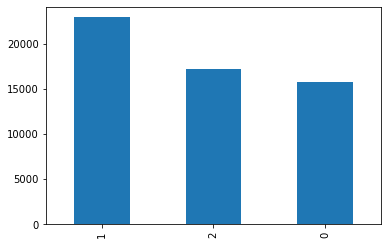

In [8]:
df.label.value_counts().plot(kind='bar')

In [9]:
'''
different preprocess functions
'''
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
#apply those functions
df['text'] = preprocess(df.text)
df['text'] = df['text'].apply(remove_urls)
df['text'] = df['text'].apply(removes)
df.text = df.text.apply(lambda x: decontracted(x).lower())


In [11]:
stop_words = stopwords.words('english')
not_stopwords = {}
common_words =['com','twitter','please',
               'the','would','could','can','may','must', 
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
df.text = df.text.apply(lambda x: rm_punc.sub(' ', x))
df.text = df.text.apply(lambda x: rm_space.sub(' ', x))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfTransformer as TF
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import MultinomialNB as MB
from sklearn.pipeline import Pipeline
import string

In [14]:
X_train, X_test, y_train, y_test = tts(df.text, df.label, random_state = 42, test_size = 0.15)

In [15]:
nb = Pipeline([('vect', CV()),
               ('clf', MB()),
              ])

In [16]:
nb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [17]:
labels = ['pos','dep','sucide']

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.9014050964515361
              precision    recall  f1-score   support

         pos       0.98      0.79      0.87      2362
         dep       0.84      0.97      0.90      3425
      sucide       0.94      0.91      0.92      2611

    accuracy                           0.90      8398
   macro avg       0.92      0.89      0.90      8398
weighted avg       0.91      0.90      0.90      8398



In [20]:

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CV(ngram_range=[0,2])),
                ('clf', LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

def get_top_k_predictions(model,X_test,k):
    probs = model.predict_proba(X_test)
    best_n = np.argsort(probs, axis=1)[:,-k:]
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    return preds

[LibLinear]accuracy 0.9611812336270541
              precision    recall  f1-score   support

         pos       0.94      0.99      0.96      2362
         dep       0.97      0.96      0.96      3425
      sucide       0.97      0.94      0.95      2611

    accuracy                           0.96      8398
   macro avg       0.96      0.96      0.96      8398
weighted avg       0.96      0.96      0.96      8398

